Analyze the progression of the frontier points algorithm with temperature change


In [1]:
pwd

'/Users/zofia/github/DFM/interactivePython'

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os
sys.path.append('/Users/zofia/github/DFM/srcDiffmap')

import mdtraj as md

import integrator
import sampler #as sampler
import model #as model
import diffusionmap as dm
import statistics_dfm as stat

import numpy as np
from simtk import openmm, unit
from openmmtools.constants import kB

import model
mdl=model.Model('Alanine')
mdlTopology=mdl.testsystem.topology
print (mdl.x_unit)
print('System has %d particle(s)' % mdl.system.getNumParticles())
print (mdl.testsystem.positions)
X0=mdl.testsystem.positions.value_in_unit(mdl.x_unit)
print('Initial distance is %f' % np.linalg.norm(X0[0,:]-X0[ 1,:]))

algoVect=0

# parameters
# this is the target temperature 
T=300.0
temperature =  T * unit.kelvin#300 * unit.kelvin
kT = kB * temperature


gamma = 1.0 / unit.picosecond
dt = 2.0 * unit.femtosecond

TemperatureTAMDFactor=30.0
massScale=50.0

gammaScale=100.0
kappaScale=1000.0

print("TemperatureTAMDFactor = " + repr(TemperatureTAMDFactor))
temperatureAlpha= (T*TemperatureTAMDFactor)* unit.kelvin

print('Gamma is '+repr(gamma))
print('Temperature is '+repr(temperature))
print('Temperature TAMD '+repr(TemperatureTAMDFactor)+'xTemperature')
print('Mass alpha is '+repr(massScale)+'x Mass')



# simulation class sampler takes integrator class with chosen parameters as input
integrator=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature, temperatureAlpha=temperatureAlpha, dt=dt, massScale=massScale, gammaScale=gammaScale, kappaScale=kappaScale)
samplerAlgo=sampler.Sampler(model=mdl, integrator=integrator, algorithm=0, dataFileName='Data')

# nrSteps is number of steps for each nrRep , and iterate the algo nrIterations times - total simulation time is nrSteps x nrIterations
# nrSteps=args.nrSteps
# nrEquilSteps = 10 #10000
# nrIterations=args.niterations
# nrRep=args.nreplicas

algoNames=samplerAlgo.algorithmName

simulatedTemperature=300

print(samplerAlgo.model.testsystem.topology)

nanometer
System has 22 particle(s)
[[  2.00000100e-01   1.00000000e-01  -1.30000000e-07]
 [  2.00000100e-01   2.09000000e-01   1.00000000e-08]
 [  1.48626400e-01   2.45384900e-01   8.89824000e-02]
 [  1.48625900e-01   2.45385200e-01  -8.89820000e-02]
 [  3.42742000e-01   2.64079500e-01  -3.00000000e-07]
 [  4.39058000e-01   1.87740600e-01  -6.60000000e-07]
 [  3.55537540e-01   3.96964880e-01  -3.10000000e-07]
 [  2.73312000e-01   4.55616010e-01  -1.30000000e-07]
 [  4.85326210e-01   4.61392530e-01  -4.30000000e-07]
 [  5.40759600e-01   4.31553880e-01   8.89815200e-02]
 [  5.66130440e-01   4.22084250e-01  -1.23214800e-01]
 [  5.12326150e-01   4.52136300e-01  -2.13120160e-01]
 [  6.63048400e-01   4.71893540e-01  -1.20579070e-01]
 [  5.80854010e-01   3.14087240e-01  -1.24138500e-01]
 [  4.71267590e-01   6.12941850e-01   1.40000000e-07]
 [  3.60064450e-01   6.65270270e-01   6.20000000e-07]
 [  5.84605330e-01   6.83488330e-01   2.50000000e-07]
 [  6.73700140e-01   6.35916200e-01  -4.000000

In [4]:
methodName =  'corner_temperature_change_off'#'corner_temperature_change_off'#'frontier_points_corner'


numberOfIterations=10

import pyemma.coordinates as coor
#print samplerAlgo[0].model.testsystem.topology
feat = coor.featurizer(md.Topology().from_openmm(samplerAlgo.model.testsystem.topology))
#print traj[0]

#feat.add_dihedrals(np.asarray([[6, 8, 14, 16], [4, 6, 8, 14]]))
feat.add_backbone_torsions()

# traj[0].unitcell_lengths=np.zeros((traj[0].xyz.shape[0],traj[0].xyz.shape[2]))
# traj[0].unitcell_angles=traj[0].unitcell_lengths
#print('/Users/zofia/github/DFM/Data/frontier_points_corner/Traj/Alaninetraj_'+repr(i)+'.h5')

#inp=[coor.load('/Users/zofia/github/DFM/Data/Alanine/std/Traj/Alaninetraj_'+repr(i)+'.h5', feat) for i in range(numberOfIterations) ] 
inp=[coor.load('/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/Traj/Alaninetraj_'+repr(i)+'.h5', feat) for i in range(numberOfIterations) ] 
#
print( np.asarray(inp).shape)

#inp = [coor.source(traj[ia].xyz, feat) for ia in range(0,len(algoVect))]
#print('number of trajectories = ',inp.number_of_trajectories())
#print('trajectory length = ',inp.trajectory_length(0))
#print('trajectory time step = ',500.0 / (inp.trajectory_length(0)-1),'ns')
#print('number of dimension = ',inp.dimension())

#print(inp)




 



(10, 5000, 2)


/Users/zofia/miniconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


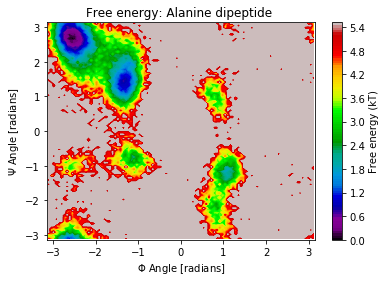

In [5]:

import pyemma.plots as mplt
from math import pi


   
Y = inp   
   
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1]);
plt.title('Free energy: Alanine dipeptide ')
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel(r'$\Psi$ Angle [radians]')
plt.ylim(-pi, pi)
    #plt.savefig(samplerAlgo[i].algorithmName+'.eps')
    #plt.show()
    #plt.savefig('freeEnergy_'+samplerAlgo[i].algorithmName+'.eps', dpi='figure', bbox_inches='tight')
plt.show()

    

In [6]:
#'/Users/zofia/github/DFM/Data/Std/Traj/*.h5'


#---------------- load trajectories: for example from simulation at higher temperature
import glob



def loadData(fileName, iteration=False):
    print('Loading data from '+ fileName)
    numpy_vars = []
    
    print(fileName+'*.h5')
    if iteration== False:
        
        for np_name in glob.glob(fileName+'*.h5'):
            numpy_vars.append(md.load(np_name))
    else:
        for np_name in glob.glob(fileName):
            numpy_vars.append(md.load(np_name))

    traj = numpy_vars
    print(len(traj))

    Xmdtraj=list()
    for i in range(len(traj)):
        #print(traj[i][0].xyz)
        Xmdtraj.append(md.Trajectory(traj[i].xyz, samplerAlgo.model.testsystem.topology))#mdl.testsystem.topology) )

    print(Xmdtraj[0].xyz.shape[2])
    L=int(Xmdtraj[0].xyz.shape[0]*len(traj))
    nrP=int(Xmdtraj[0].xyz.shape[1])
    print(nrP)
    D=int(Xmdtraj[0].xyz.shape[2])
    X=np.zeros((L, nrP, D))
    for i in range(0,len(Xmdtraj)):
            X[i*len(Xmdtraj[i].xyz):(i+1)*len(Xmdtraj[i].xyz),:,:]=Xmdtraj[i].xyz
    
    Xmdtraj = md.Trajectory(X, mdlTopology )
    
    return X, traj, Xmdtraj


In [7]:

#nameData = '/Users/zofia/github/DFM/Data/frontier_points_change_temperature/Traj/'
#nameData = '/Users/zofia/github/DFM/Data/frontier_points/Traj/'
#nameData = '/Users/zofia/github/DFM/Data/Alanine/std/Traj/'
nameData = '/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/Traj/'



X_FT, traj_FT, Xmdtraj_FT = loadData(nameData)


Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/*.h5
10
3
22


In [8]:
# #print(Xmdtraj_FT[0].xyz)
# def computeRMSD(Xmdtraj_FT):
#     rmsd=np.zeros(len(Xmdtraj_FT))
#     for i in range(len(Xmdtraj_FT)):
#         rmsd[i]= md.rmsd(Xmdtraj_FT[0], Xmdtraj_FT[i])
#     #print(rmsd)
#     return rmsd

# rmsd=computeRMSD(Xmdtraj_FT)
# plt.plot(range(len(rmsd)),rmsd)
# plt.legend(['RMSD'])


# plt.show()



In [9]:
# load saved frontier points 


#nameData = '/Users/zofia/github/DFM/Data/frontier_points_change_temperature/Traj/'
#nameData = '/Users/zofia/github/DFM/Data/frontier_points/Traj/'
#nameData = '/Users/zofia/github/DFM/Data/Alanine/std/Traj/'
nameDataFrontier = '/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/Traj/FrontierPoints/'


X_frontier, bla, Xmd_frontier = loadData(nameDataFrontier)

Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/*.h5
10
3
22


In [10]:
#plot sampled trajctories
def plotSamplingDihedrals(nameData, nameFrontier, samplerAlgo, singleDataFrame=False):
    
    psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
    top=md.Topology().from_openmm(samplerAlgo.model.testsystem.topology)
    
    if singleDataFrame==True:
        for i in range(len(nameData)):
        
            X_FT, bla, Xmd_FT = loadData(nameData[i], iteration=True)
            
            inp=md.Trajectory(X_FT, top)

            angles = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
            plt.scatter(angles[:, 0], angles[:, 1], s=5, c='b');
            
    
    else:
            X_FT, bla, Xmd_FT = loadData(nameData)
            inp=md.Trajectory(X_FT, top)

            angles = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
            plt.scatter(angles[:, 0], angles[:, 1], s=5, c='b');

    #load frontier points
    if singleDataFrame==True:
            
            X_frontier, bla, Xmd_frontier = loadData(nameFrontier, iteration=True)
    else:
            
            X_frontier, bla, Xmd_frontier = loadData(nameFrontier)
    inpFrontierPoints = md.Trajectory(X_frontier, top)
    anglesFrontierPoints = md.geometry.compute_dihedrals(inpFrontierPoints, [phi_indices, psi_indices]) 
            
    plt.scatter(anglesFrontierPoints[:, 0], anglesFrontierPoints[:, 1], c='r');
    
    plt.title('Alanine dipeptide ')
    plt.xlabel(r'$\Phi$ Angle [radians]')
    plt.xlim(-pi, pi)
    plt.ylabel(r'$\Psi$ Angle [radians]')
    plt.ylim(-pi, pi)
    plt.show()

   

#plot sampled trajectories
def plotSamplingDihedralsEigenvectors(nameData, nameFrontier, nameEigenvector, samplerAlgo, singleDataFrame=False):
    
    psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
    top=md.Topology().from_openmm(samplerAlgo.model.testsystem.topology)
    
    if singleDataFrame==True:
        
        
            X_FT, bla, Xmd_FT = loadData(nameData, iteration=True)
            
            inp=md.Trajectory(X_FT, top)
            
            FEV=np.load(nameEigenvector)
            V1=FEV[:,0]

            angles = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
            print(V1.shape)
            plt.scatter(angles[:, 0], angles[:, 1], s=5, c=V1);
           
            
            
    
    else:
            X_FT, bla, Xmd_FT = loadData(nameData)
            inp=md.Trajectory(X_FT, top)

            angles = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
            plt.scatter(angles[:, 0], angles[:, 1], s=5, c='b');

    #load frontier points
    if singleDataFrame==True:
            
            X_frontier, bla, Xmd_frontier = loadData(nameFrontier, iteration=True)
    else:
            
            X_frontier, bla, Xmd_frontier = loadData(nameFrontier)
    inpFrontierPoints = md.Trajectory(X_frontier, top)
    anglesFrontierPoints = md.geometry.compute_dihedrals(inpFrontierPoints, [phi_indices, psi_indices]) 
            
    plt.scatter(anglesFrontierPoints[:, 0], anglesFrontierPoints[:, 1], c='r');
    
    plt.title('Alanine dipeptide ')
    plt.xlabel(r'$\Phi$ Angle [radians]')
    plt.xlim(-pi, pi)
    plt.ylabel(r'$\Psi$ Angle [radians]')
    plt.ylim(-pi, pi)
    
    plt.show()


corner_temperature_change_off
Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_0.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_0.h5*.h5
1
3
22
(1000,)
Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_0.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_0.h5*.h5
1
3
22


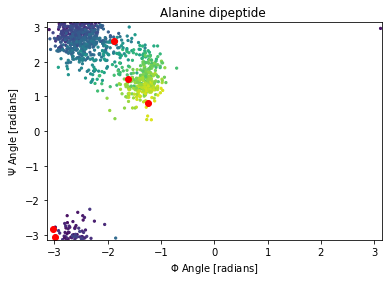

Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_1.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_1.h5*.h5
1
3
22
(2000,)
Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_1.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_1.h5*.h5
1
3
22


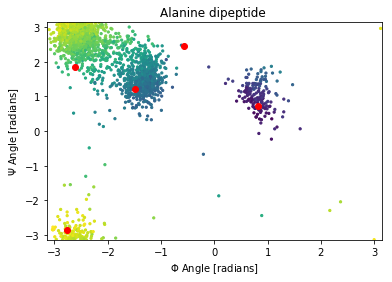

Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_2.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_2.h5*.h5
1
3
22
(600,)
Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_2.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_2.h5*.h5
1
3
22


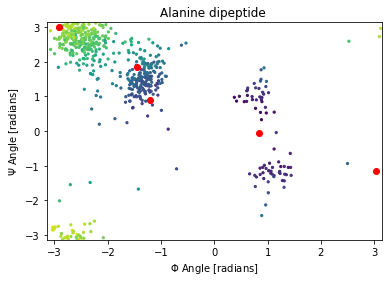

Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_3.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_3.h5*.h5
1
3
22
(800,)
Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_3.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_3.h5*.h5
1
3
22


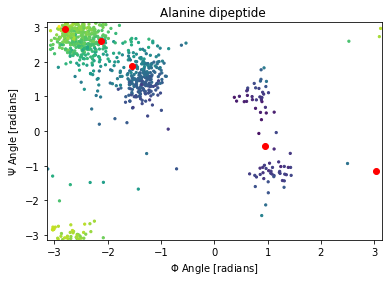

Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_4.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_4.h5*.h5
1
3
22
(1000,)
Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_4.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_4.h5*.h5
1
3
22


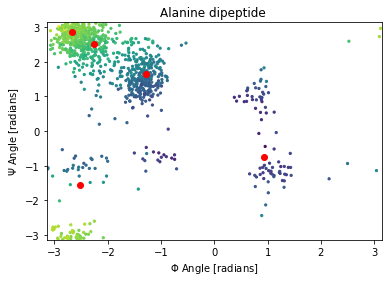

Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_5.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_5.h5*.h5
1
3
22
(1200,)
Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_5.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_5.h5*.h5
1
3
22


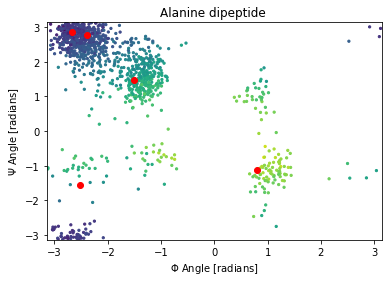

Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_6.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_6.h5*.h5
1
3
22
(1400,)
Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_6.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_6.h5*.h5
1
3
22


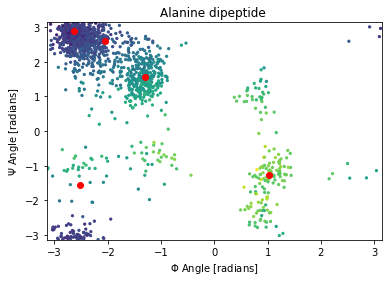

Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_7.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_7.h5*.h5
1
3
22
(1600,)
Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_7.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_7.h5*.h5
1
3
22


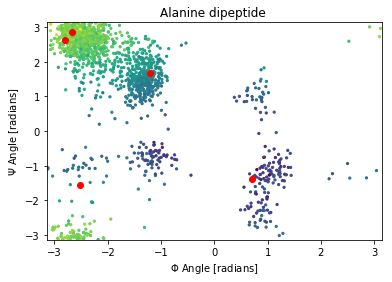

Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_8.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_8.h5*.h5
1
3
22
(1800,)
Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_8.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_8.h5*.h5
1
3
22


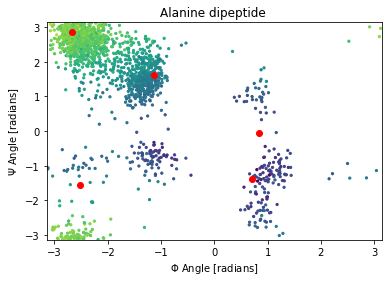

Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_9.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_9.h5*.h5
1
3
22
(2000,)
Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_9.h5
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_9.h5*.h5
1
3
22


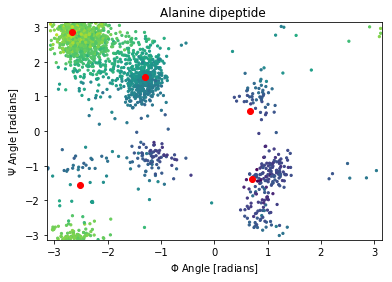

In [15]:
nameData_i_list=list()

print(methodName)
for i in range(numberOfIterations):
    
    nameData_i = '/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/Traj/Eigenvectors/traj_'+repr(i)+'.h5'
    nameDataEigenvector_i = '/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/Traj/Eigenvectors/V1_'+repr(i)+'.npy'
    nameDataFrontier_i = '/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/Traj/FrontierPoints/frontierPoints_at_iteration_'+repr(i)+'.h5'
    plotSamplingDihedralsEigenvectors(nameData_i, nameDataFrontier_i, nameDataEigenvector_i, samplerAlgo, singleDataFrame=True)

Loading data from /Users/zofia/github/DFM/Data/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5
/Users/zofia/github/DFM/Data/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/Data/Alanine/frontier_points_corner/Traj/FrontierPoints/frontierPoints_at_iteration_0.h5
/Users/zofia/github/DFM/Data/Alanine/frontier_points_corner/Traj/FrontierPoints/frontierPoints_at_iteration_0.h5*.h5
1
3
22


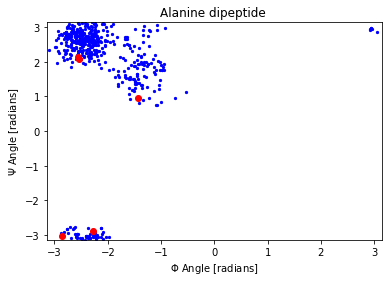

Loading data from /Users/zofia/github/DFM/Data/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5
/Users/zofia/github/DFM/Data/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/Data/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5
/Users/zofia/github/DFM/Data/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/Data/Alanine/frontier_points_corner/Traj/FrontierPoints/frontierPoints_at_iteration_1.h5
/Users/zofia/github/DFM/Data/Alanine/frontier_points_corner/Traj/FrontierPoints/frontierPoints_at_iteration_1.h5*.h5
1
3
22


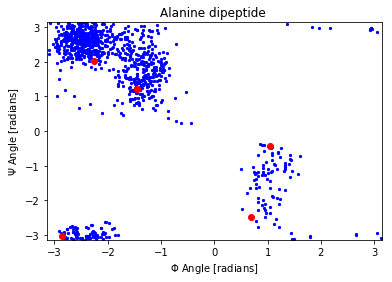

Loading data from /Users/zofia/github/DFM/Data/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5
/Users/zofia/github/DFM/Data/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/Data/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5
/Users/zofia/github/DFM/Data/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/Data/Alanine/frontier_points_corner/Traj/Alaninetraj_2.h5
/Users/zofia/github/DFM/Data/Alanine/frontier_points_corner/Traj/Alaninetraj_2.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/Data/Alanine/frontier_points_corner/Traj/FrontierPoints/frontierPoints_at_iteration_2.h5
/Users/zofia/github/DFM/Data/Alanine/frontier_points_corner/Traj/FrontierPoints/frontierPoints_at_iteration_2.h5*.h5
1
3
22


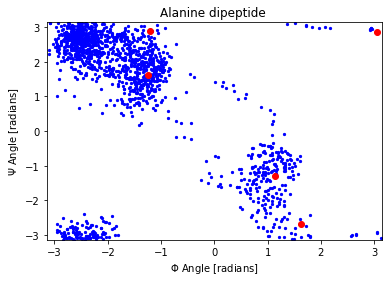

In [11]:
nameData_i_list=list()
for i in range(numberOfIterations):
    
    nameData_i = '/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/Traj/Alaninetraj_'+repr(i)+'.h5'
    nameDataFrontier_i = '/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/Traj/FrontierPoints/frontierPoints_at_iteration_'+repr(i)+'.h5'
    nameData_i_list.append(nameData_i)
    plotSamplingDihedrals(nameData_i_list, nameDataFrontier_i, samplerAlgo, singleDataFrame=True)

Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/*.h5
10
3
22
Loading data from /Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/
/Users/zofia/github/DFM/Data/Alanine/corner_temperature_change_off/Traj/FrontierPoints/*.h5
10
3
22


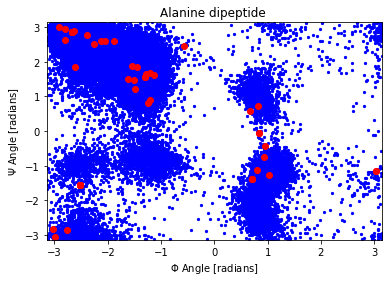

In [12]:
plotSamplingDihedrals(nameData, nameDataFrontier, samplerAlgo)

In [13]:
import imp
imp.reload(sampler)
imp.reload(dm)
imp.reload(stat)

def getDominantEigenvector(tr, eps, numberOfLandmarks, smpl, model, T, method): 
        
        tr_orig=tr
        
        tmp=md.Trajectory(tr, model.testsystem.topology)
        tmp = tmp.superpose(tmp[0])
        #------ reshape data ------------------------------

        tmp =  tmp.xyz.reshape((tmp.xyz.shape[0], tmp.xyz.shape[1]*tmp.xyz.shape[2]))
                
        tr=tmp
        v1, qTarget, qEmp, Epot, kernel=sampler.dominantEigenvectorDiffusionMap(tr, eps, smpl, T, method)
        
        #qTargetNormalized = qTarget/np.sum(qTarget)
        
        #get landmarks
        lm, levelsets, linspV = dm.get_landmarks(tr, numberOfLandmarks, qTarget, v1, Epot, getLevelSets=True)
        
        levelsets, levels = dm.get_levelsets(tr, numberOfLandmarks, qTarget, v1);
        
        tr =  tr.reshape((tr_orig.shape[0], tr_orig.shape[1],tr_orig.shape[2]))
        
        return tr, levelsets, v1, lm, qEmp, Epot, qTarget


def computeFreeEnergyAtLandmarkedPoint(qTarget, qEmp, levelsets, method='weighted'):
      
        if(method=='weighted'):
            weight, Ntilde = stat.compute_weight_target_distribution(qTarget, qEmp)
        
        
        K=len(levelsets)
        
        freeEnergy=np.zeros(K)
        h=np.zeros(K)

        for k in range(0,K):
            # simple histogram
            if(method == 'raw'):
                h[k] = np.sum(len(levelsets[k]))
            elif(method=='weighted'):
#              # unbiased histogram- we can use weights!!
                h[k] = np.sum(weight[levelsets[k]])
            
        for k in range(0,K):
            if(h[k] == 0):
                freeEnergy[k] = 0 # if the bin is empty set 0
            else:
                if(method == 'raw'):
                    freeEnergy[k] = -np.log(h[k]/sum(h))
                elif(method=='weighted'):
#              
                    freeEnergy[k] =  -np.log( h[k]/sum(h) / Ntilde)
                
                
        
                
        if(method=='weighted'):
            return freeEnergy, weight, Ntilde
        else:
            return freeEnergy

        
def computeFreeEnergyAtEveryPoint(X, V1, width, qTarget, qEmp, method='weighted'):
      
        if(method=='weighted'):
            weight, Ntilde = stat.compute_weight_target_distribution(qTarget, qEmp)
        
        
     
        freeEnergy=np.zeros(len(X))
        h=np.zeros(len(X))

        for k in range(0,len(X)):
            
            levelset = dm.get_levelset_onePoint(k, width, V1)
            #print(len(levelset))
            
            # simple histogram
            if(method == 'raw'):
                h[k] = np.sum(len(levelset))
            elif(method=='weighted'):
#              # unbiased histogram- we can use weights!!
                h[k] = np.sum(weight[levelset])
    
            
        for k in range(0,len(X)):
            if(h[k] == 0):
                freeEnergy[k] = 0 # if the bin is empty set 0
            else:
                if(method == 'raw'):
                    freeEnergy[k] = -np.log(h[k]/sum(h))
                elif(method=='weighted'):
#              
                    freeEnergy[k] =  -np.log( h[k]/sum(h) / Ntilde)
                
                
        
                
        if(method=='weighted'):
            return freeEnergy, weight, Ntilde
        else:
            return freeEnergy


        
        
        

#

In [14]:
numberOfLandmarks=10
epsilon=1

Xshort=X_FT
print(len(Xshort))
while(len(Xshort)>2000):
    Xshort=Xshort[::2]
#Xshort=X[::10]
print("Shape of input data: "+repr((Xshort.shape)))

# # note that samplerAlgo.T gives the target temperature from the at the beginning initialized class
# print("Target temperature is "+repr(samplerAlgo.T))



Xsp_FT,levelsets_FT, V1_FT, lm_FT, qEmp_FT, Epot_FT, qTarget_FT =getDominantEigenvector(Xshort, epsilon, numberOfLandmarks, samplerAlgo, samplerAlgo.model, samplerAlgo.T, 'TMDiffmap')#'TMDiffmap')#'Diffmap')

#freeEnergy_FT, weight_FT, Ntilde_FT = computeFreeEnergyAtLandmarkedPoint(qTarget_FT, qEmp_FT, levelsets_FT, method='weighted')


50000
Shape of input data: (1563, 22, 3)
Temperature in dominantEigenvectorDiffusionMap is Quantity(value=300.0, unit=kelvin)
constructing neighbor graph


KeyboardInterrupt: 

In [ ]:
width=0.1
freeEnergy = computeFreeEnergyAtEveryPoint(Xsp_FT, V1_FT, width, qTarget_FT, qEmp_FT, method='raw')
#print(freeEnergy)

In [ ]:
top=md.Topology().from_openmm(samplerAlgo.model.testsystem.topology)
inpShort=md.Trajectory(Xsp_FT, top)

psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
angles = md.geometry.compute_dihedrals(inpShort, [phi_indices, psi_indices]) 


print((Xsp_FT.shape))
plt.scatter(angles[:, 0], angles[:, 1], c=freeEnergy, s=10);#, c=V1_FT);
plt.title('Dominant eigenvector: Alanine dipeptide ')
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel(r'$\Psi$ Angle [radians]')
plt.ylim(-pi, pi)
    #plt.savefig(samplerAlgo[i].algorithmName+'.eps')
    #plt.show()
    #plt.savefig('freeEnergy_'+samplerAlgo[i].algorithmName+'.eps', dpi='figure', bbox_inches='tight')
plt.colorbar()
plt.show()

plt.scatter(angles[:, 0], angles[:, 1], c=V1_FT, s=10);#, c=V1_FT);
plt.title('Dominant eigenvector: Alanine dipeptide ')
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel(r'$\Psi$ Angle [radians]')
plt.ylim(-pi, pi)
    #plt.savefig(samplerAlgo[i].algorithmName+'.eps')
    #plt.show()
    #plt.savefig('freeEnergy_'+samplerAlgo[i].algorithmName+'.eps', dpi='figure', bbox_inches='tight')
plt.colorbar()
plt.show()



plt.scatter(angles[:, 0], V1_FT, s=5);
plt.title('Does V1 correlate with dihedral angles? ')
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel('V1')

plt.show()

plt.scatter(angles[:, 1], V1_FT, s=5);
plt.title('Does V1 correlate with dihedral angles? ')
plt.xlabel(r'$\Psi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel('V1')

plt.show()

plt.scatter(angles[:, 0], freeEnergy, s=5);
plt.title('Free energy? ')
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel('FE')

plt.show()

plt.scatter(angles[:, 1], freeEnergy, s=5);
plt.title('Free energy? ')
plt.xlabel(r'$\Psi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel('FE')

plt.show()

plt.scatter(V1_FT, freeEnergy, s=5);
plt.title('Free energy? ')
plt.xlabel(r'$\Psi$ Angle [radians]')
plt.xlabel(r'V1')

plt.ylabel('FE')

plt.show()

In [ ]:
# Averages
imp.reload(stat)
imp.reload(dm)
#print(samplerAlgo.model.energy)
#print(weight)



weight, Ntilde = stat.compute_weight_target_distribution(qTarget_FT, qEmp_FT)
print('mean weight is '+repr(np.mean(weight)))

#-----------average energy
meanV = stat.computeAverages(Xshort, samplerAlgo.model.energy, units=samplerAlgo.model.energy_unit)
meanVunbiased = stat.computeUnbiasedAverages(Xshort, samplerAlgo.model.energy, weight, units=samplerAlgo.model.energy_unit)

print('Raw:')
print('<V> = '+repr(meanV*samplerAlgo.model.energy_unit))

print('\nUnbiased:')
print('<V> = '+repr(meanVunbiased*samplerAlgo.model.energy_unit))


#---------- average rmsd

#give the rmsd vector
rmsdShort=computeRMSD(inpShort)

meanR = stat.computeAverages(Xshort, rmsdShort, vectorFunction=True)
meanRunbiased = stat.computeUnbiasedAverages(Xshort, rmsdShort, weight, vectorFunction=True)

print('Raw:')
print('<rmsd> = '+repr(meanR*samplerAlgo.model.x_unit))

print('\nUnbiased:')
print('<rmsd> = '+repr(meanRunbiased*samplerAlgo.model.x_unit))




In [ ]:
#---------- VISUALISATION OF THE MOLECULE
#align according to first frame

traj=traj_FT
traj[0]=traj[0].superpose(traj[0][0])
tpl=traj[0].topology
print(tpl)
import nglview as nv
view = nv.show_mdtraj(traj[0])

#view.add_representation('spacefill', selection='all' )
#view.add_representation('cartoon', selection='protein', color='blue')
view.add_representation('licorice', selection='all', color='red')
#view.frame = 10
view

#--- saving as gif: does not work :(
# from nglview.contrib.movie import MovieMaker
# movie = MovieMaker(view, output='my.gif')
# movie.make()
